## Face detection

La ProCam s.p.a ha intenzione di lanciare sul mercato una nuova fotocamera digitale compatta ed economica destinata a piccoli fotografi in erba.

Vieni assunto come Data Scientist per realizzare il sistema di identificazione dei volti nelle immagini, questo permetterà poi ai tecnici della fotografia di ottimizzare le impostazioni per un selfie con una o più persone.

Si tratta di un problema di computer vision, più precisamente di Face Detection.

Devi fornire una pipeline scikit-learn che prende un'immagine in ingresso e ritorna una lista con le coordinate dei bounding box dove sono presenti dei volti, se nell'immagine non contiene volti la lista sarà ovviamente vuota.

- Non ti viene fornito un dataset, sta a te cercarne uno in rete o, nella peggiore delle ipotesi, costruirlo, per semplicità non considereremo implicazioni sulle licenze ad utilizzo commerciale, si tratta pur sempre di un progetto didattico.
- Non puoi utilizzare modelli pre-addestrati, devi addestrarlo tu utilizzando scikit-learn.
- Stai lavorando su un sistema con ridotte capacità di calcolo, quindi il modello deve richiedere poche risorse di calcolo.
- Ovviamente non ti vengono fornite indicazioni sull'implementazione, fai un'approfondita ricerca bibliografica per trovare la soluzione migliore da adottare, il notebook che consegnerai deve essere ben documentato, devi spiegare quali soluzioni hai adottato e perché ed ogni risorsa esterna (paper, blog post, codice github...) che hai utilizzato.
- Il progetto è abbastanza complesso, ricorda che in caso ne avessi necessità puoi sempre chiedere aiuto ai tuoi coach nella Classe Virtuale di Machine Learning su Discord.

https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

Import object images from kaggle

In [1]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


Butterfly dataset (832 images). 

It contains bufferflies images with some flowers and plants. With this dataset model can learn to detect naturalistic objects.

In [2]:
!kaggle datasets download veeralakrishna/butterfly-dataset

Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset
License(s): Community Data License Agreement - Permissive - Version 1.0
butterfly-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# !unzip butterfly-dataset.zip -d butterfly-dataset
# !tar -xf butterfly-dataset.zip

Background dataset (715 images).

It contains some backgournd images, taken from streets and landscape photos. With this dataset model can learn to detect common background objects and patterns.

In [4]:
!kaggle datasets download -p stanford-background-dataset balraj98/stanford-background-dataset 

Dataset URL: https://www.kaggle.com/datasets/balraj98/stanford-background-dataset
License(s): other
stanford-background-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# !unzip stanford-background-dataset.zip -d stanford-background-dataset
# !tar -xf stanford-background-dataset/stanford-background-dataset.zip -C stanford-background-dataset

Add some animals pcitures :)

In [6]:
!kaggle datasets download -p animals alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!tar -xf animals/animals10.zip -C animals

In [8]:
!kaggle datasets download -p wildlife biancaferreira/african-wildlife
!tar -xf wildlife/african-wildlife.zip -C wildlife

Dataset URL: https://www.kaggle.com/datasets/biancaferreira/african-wildlife
License(s): unknown
african-wildlife.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
#Import some modules
from tqdm import tqdm
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.exposure import rescale_intensity
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from ImageResizer import ImageResizer
from HOGFeatureExtractor import HOGFeatureExtractor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import lognorm
from scipy.stats import genhalflogistic
from scipy.stats import powerlaw
from sklearn.metrics import classification_report


In [10]:
RANDOM_SEED=200
random.seed(RANDOM_SEED)

Prima di tutto provo a leggere le immagini di esempio di sklearn e provo ad estrarre hog features da questo... Il resto dopo

In [11]:
#impoort first dataset (faces)
# lfw_people = fetch_lfw_people(resize=1)
olivetti_faces=fetch_olivetti_faces()

# images_positive = lfw_people.images

#use only a portion of these images, to don't unbalance final dataset
# indexes = np.random.choice(len(lfw_people.images),1600, replace=False)
# images_positive = lfw_people.images[indexes]


images_positive = olivetti_faces.images
#some helper variables
#size = 64 x 128 as original paper
# resize_shape = (128, 64) #as row x columns (h x w)
resize_shape = (64, 64) #as row x columns (h x w)


In [12]:
X_positive = images_positive
y_positive = np.ones(X_positive.shape[0])
print(X_positive.shape) #3 dimensions: 1 = records, 2-3 = image as matrix 
print(y_positive.shape)

(400, 64, 64)
(400,)


In [13]:
print(X_positive[1,:,:].shape)

(64, 64)


In [14]:
#process negative images V2
negative_images = []

buffalo_img_dir = "wildlife/buffalo"
elephant_img_dir = "wildlife/elephant"
rhino_img_dir = "wildlife/rhino"
zebra_img_dir = "wildlife/zebra"

negative_img_dirs = [buffalo_img_dir,
                     elephant_img_dir,
                     rhino_img_dir,
                     zebra_img_dir                 
                    ]

# for directory in tqdm(negative_img_dirs,desc="Dataset:",unit="item"):
for directory in negative_img_dirs:
    filenames = os.listdir(directory)
    jpg_files = [f for f in filenames if f.endswith('.jpg')]
    #with 4 directories I get 400 negative images that balance positive images numerosity (400) 
    sampled_files=random.sample(jpg_files,100)


    for filename in tqdm(sampled_files,desc=f"Processing negative images ({directory})",
                        unit="item"):
        
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            img_path = os.path.join(directory, filename)
            img = imread(img_path, as_gray=True)
            #this resize is necessary for concatenation in a single numpy array
            img = resize(img, X_positive[1,:,:].shape)
            negative_images.append(img)

X_negative = np.array(negative_images)
y_negative = np.zeros(X_negative.shape[0])
print(X_negative.shape) #3 dimensions: 1 = records, 2-3 = image as matrix 
print(y_negative.shape)

Processing negative images (wildlife/zebra): 100%|██████████| 100/100 [00:03<00:00, 25.70item/s]

(400, 64, 64)
(400,)


In [15]:
#process negative images
# negative_images = []

# butterflies_img_dir = 'leedsbutterfly/images'
# background_img_dir = 'stanford-background-dataset/images'
# cat_img_dir = 'animals/raw-img/gatto'
# chicken_img_dir = 'animals/raw-img/gallina'
# cow_img_dir = 'animals/raw-img/mucca'
# squirrel_img_dir = 'animals/raw-img/scoiattolo'
# sheep_img_dir = 'animals/raw-img/pecora'
# negative_img_dirs = [butterflies_img_dir,
#                      background_img_dir,
#                      cat_img_dir,
#                      chicken_img_dir,
#                      cow_img_dir,
#                      squirrel_img_dir,
#                      sheep_img_dir                    
#                     ]

# # for directory in tqdm(negative_img_dirs,desc="Dataset:",unit="item"):
# for directory in negative_img_dirs:
#     for filename in tqdm(os.listdir(directory),desc=f"Processing negative images ({directory})",
#                         unit="item"):
#         if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
#             img_path = os.path.join(directory, filename)
#             img = imread(img_path, as_gray=True)
#             #this resize is necessary for concatenation in a single numpy array
#             img = resize(img, X_positive[1,:,:].shape)
#             negative_images.append(img)

# X_negative = np.array(negative_images)
# y_negative = np.zeros(X_negative.shape[0])
# print(X_negative.shape) #3 dimensions: 1 = records, 2-3 = image as matrix 
# print(y_negative.shape)

In [16]:
X = np.vstack((X_positive, X_negative))
y = np.concatenate([y_positive,y_negative])

print(X.shape)
print(y.shape)

(800, 64, 64)
(800,)


Primo tentativo di pipeline...

In [17]:
# Definisci la pipeline
pipeline = Pipeline(steps=[
    ('resizer', ImageResizer(resize_shape)),
    ('hog', HOGFeatureExtractor()),
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=RANDOM_SEED)), 
    ('svc', SVC(max_iter=5000))
], 
memory="pipe_cache")


# Addestra il modello (edit: si fa con il random search)
#pipeline.fit(X, y)

pipeline

Pipeline(memory='pipe_cache',
         steps=[('resizer', ImageResizer(resize_shape=(64, 64))),
                ('hog', HOGFeatureExtractor()), ('scaler', StandardScaler()),
                ('pca', PCA(random_state=200)), ('svc', SVC(max_iter=5000))])

Random search optimization

Effetto di C (deve essere positivo):
- se C aumenta, ho più classificazioni corrette, ho margine più stretto e quindi meno vettori di supporto (fit più lungo per cercare i SV)
- se C diminuiusce, ho più errori, ho margine più largo e quindi ho più vettori di supporto (predizione più lunga)

Effetto di gamma (deve essere positivo):
- se gamma aumenta, i vettori di supporto influenzano una zona più ristretta, quindi ottengo un decision boundary più accartocciato attorno ai SV (quindi più probabile overfitting)
- se gamma diminuisce i SV influenzano una zona più larga, ho un decision boundary più liscio e semplice (perdo la forma dei dati, underfitting)

https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py

In [18]:
#uniform distribution, such that all values are equally probable
C_range = uniform(loc=0.001, scale=100.0)
#lognorm distribution, such that lower values are more probable (if gamma is too high, decision boundary is too close to SV and i have overfitting)
gamma_range = lognorm(s=0.95, loc=0, scale=1)
degree_range = list(range(3,11))
#i want negative skewness here (higher values are preferred)
# n_components_range = powerlaw(3.7)
# n_components_range=[50,100,150,200]
n_components_range=[100,150,200,250]

grid = [{
    "pca__n_components":n_components_range,
    "svc__kernel" : ["rbf"],
    # "svc__gamma" : gamma_range,
    "svc__C" : C_range
}]
# {
#     "pca__n_components":n_components_range,
#     "svc__kernel" : ["poly"],
#     "svc__gamma" : gamma_range,
#     "svc__C" : C_range,
#     "svc__degree": degree_range
# }]

search = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=grid,
                            n_iter=20,
                            cv=5,
                            scoring="accuracy",
                            verbose=4,
                            random_state=RANDOM_SEED,
                            n_jobs=1)

# x = np.linspace(genhalflogistic.ppf(0.01, 1),
#                 genhalflogistic.ppf(0.99, 1), 100)
# plt.plot(x, genhalflogistic.pdf(x, 1),
#        'r-', lw=5, alpha=0.6, label='genhalflogistic pdf')

# plt.show()

# b=3.7
# x = np.linspace(powerlaw.ppf(0.01, b),
#                 powerlaw.ppf(0.99, b), 100)
# plt.plot(x, powerlaw.pdf(x, b),
#        'r-', lw=5, alpha=0.6, label='powerlaw pdf')

# plt.show()



In [19]:
#train test split is really needed? I could use whole dataset as train-valid set and use custom images as test 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED,stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# pipeline.fit(X_train, y_train)
search.fit(X_train, y_train)

(640, 64, 64)
(160, 64, 64)
(640,)
(160,)
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END pca__n_components=200, svc__C=49.41536292718904, svc__kernel=rbf;, score=1.000 total time=   1.4s
[CV 2/5] END pca__n_components=200, svc__C=49.41536292718904, svc__kernel=rbf;, score=1.000 total time=   1.2s
[CV 3/5] END pca__n_components=200, svc__C=49.41536292718904, svc__kernel=rbf;, score=1.000 total time=   1.4s
[CV 4/5] END pca__n_components=200, svc__C=49.41536292718904, svc__kernel=rbf;, score=1.000 total time=   1.4s
[CV 5/5] END pca__n_components=200, svc__C=49.41536292718904, svc__kernel=rbf;, score=1.000 total time=   1.4s
[CV 1/5] END pca__n_components=100, svc__C=59.443014439113256, svc__kernel=rbf;, score=1.000 total time=   0.3s
[CV 2/5] END pca__n_components=100, svc__C=59.443014439113256, svc__kernel=rbf;, score=1.000 total time=   0.3s
[CV 3/5] END pca__n_components=100, svc__C=59.443014439113256, svc__kernel=rbf;, score=1.000 total time=   0.4s
[CV 4

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(memory='pipe_cache',
                                      steps=[('resizer',
                                              ImageResizer(resize_shape=(64,
                                                                         64))),
                                             ('hog', HOGFeatureExtractor()),
                                             ('scaler', StandardScaler()),
                                             ('pca', PCA(random_state=200)),
                                             ('svc', SVC(max_iter=5000))]),
                   n_iter=20, n_jobs=1,
                   param_distributions=[{'pca__n_components': [100, 150, 200,
                                                               250],
                                         'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000128064E0610>,
                                         'svc__kernel': ['rbf']}],
                   random_state=200, scoring='accuracy', verbose=4)

In [20]:
print(f"Best parameters: {search.best_params_}")
print(f"Best accuracy: {search.best_score_}")

Best parameters: {'pca__n_components': 200, 'svc__C': 49.41536292718904, 'svc__kernel': 'rbf'}
Best accuracy: 1.0


In [21]:
search.best_estimator_

Pipeline(memory='pipe_cache',
         steps=[('resizer', ImageResizer(resize_shape=(64, 64))),
                ('hog', HOGFeatureExtractor()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=200, random_state=200)),
                ('svc', SVC(C=49.41536292718904, max_iter=5000))])

Model evaluation

In [22]:
y_pred = search.predict(X_test)
print(classification_report(y_test, y_pred,digits=4))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000        80
         1.0     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       160
   macro avg     1.0000    1.0000    1.0000       160
weighted avg     1.0000    1.0000    1.0000       160

[[80  0]
 [ 0 80]]


In [23]:
import joblib
joblib.dump(search.best_estimator_,"model.joblib")

['model.joblib']

In [39]:
# print(pipeline.predict([X[-100,:,:]]))
def sliding_window(image, step_size, window_size):
    # get the window and image sizes
    w, h = window_size
    image_h, image_w = image.shape[:2]

    # loop over the image, taking steps of size `step_size`
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window is below the minimum window size, ignore it
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)

Pyramid shape: (4000, 6000)
	Face detected at (4740, 800)
	Face detected at (5220, 3860)
Pyramid shape: (2000, 3000)
	Face detected at (200, 920)
	Face detected at (860, 1320)
Pyramid shape: (1000, 1500)
Pyramid shape: (500, 750)
Pyramid shape: (250, 375)
Pyramid shape: (125, 188)
Pyramid shape: (63, 94)
Breaking loop


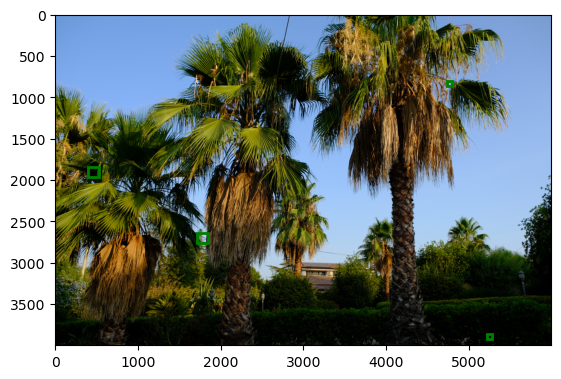

In [41]:
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray
image_or = imread("img8.jpg")
image = rgb2gray(image_or)
# image = equalize_hist(image)
# w, h = 64, 128
w, h = 64, 64
bounding_boxes = []
downscale = 2

for resized_img in pyramid_gaussian(image, downscale=downscale):
    print(f"Pyramid shape: {resized_img.shape}")
    if resized_img.shape[0] < h or resized_img.shape[1] < w:
        print("Breaking loop")
        break

    for (x_win, y_win, window) in sliding_window(resized_img, step_size=20, window_size=(w, h)):
        prediction = search.predict(window)
        print(search.decision_function(window))
        #replace with saving bounding box info
        if(prediction[0] == 1):
            print(f"\tFace detected at ({x_win}, {y_win})")
            scale_factor = image.shape[0]/resized_img.shape[0]
            x_original = int(x_win*scale_factor)
            y_orignal = int(y_win*scale_factor)
            width_orignal = int(w*scale_factor)
            height_oringal = int(h*scale_factor)
            bounding_boxes.append((x_original,y_orignal,width_orignal,height_oringal)) # (x, y, width, height)


import matplotlib.patches as patches
#display bounding boxes inside image
plt.imshow(image_or)
for (x_box, y_box, width, height) in bounding_boxes:
    rect = patches.Rectangle((x_box, y_box), width, height, linewidth=2, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

In [30]:
print(window.shape)

(64, 64)


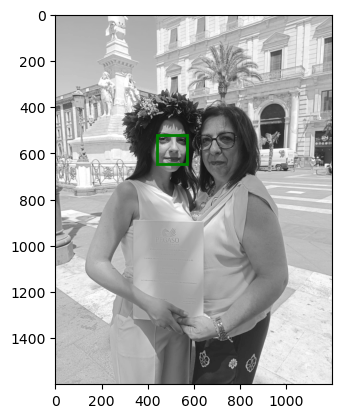

In [31]:
import matplotlib.patches as patches
#display bounding boxes inside image
plt.imshow(image, cmap="gray")
for (x_box, y_box, width, height) in bounding_boxes:
    rect = patches.Rectangle((x_box, y_box), width, height, linewidth=2, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

https://scikit-learn.org/stable/modules/compose.html

https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py

https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py